In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras as keras
from tensorflow.keras import regularizers
from tensorflow.keras.initializers import GlorotNormal
from tensorflow.keras.metrics import TruePositives, FalsePositives, TrueNegatives, FalseNegatives, BinaryAccuracy, Precision, Recall, AUC
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pandas as pd
import os
import time
import cv2
import pathlib
import matplotlib as mpl

2024-05-23 14:54:42.676848: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-23 14:54:42.676942: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-23 14:54:42.824203: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
img_width = 224
img_height = 224
batch_size = 32
color = 3
dataset_folder ="/kaggle/input/datafruit-after/datefruitAfter/data fruit"
classes_name = [ 'Galaxy', 'Medjool', 'Meneifi', 'Nabtat Ali', 'Rutab', 'Shaishe', 'Sokari', 'Sugaey']

In [3]:
dataset_path = pathlib.Path(dataset_folder)


In [4]:
def directory_dataset(dataset_path):
    folders = []
    for subdirectory in dataset_path.iterdir():
        if subdirectory.is_dir():
            folders.append(subdirectory)
    return folders

In [5]:
folders = directory_dataset(dataset_path)
print(folders)

[PosixPath('/kaggle/input/datafruit-after/datefruitAfter/data fruit/Galaxy'), PosixPath('/kaggle/input/datafruit-after/datefruitAfter/data fruit/Rutab'), PosixPath('/kaggle/input/datafruit-after/datefruitAfter/data fruit/Sugaey'), PosixPath('/kaggle/input/datafruit-after/datefruitAfter/data fruit/Medjool'), PosixPath('/kaggle/input/datafruit-after/datefruitAfter/data fruit/Nabtat Ali'), PosixPath('/kaggle/input/datafruit-after/datefruitAfter/data fruit/Sokari'), PosixPath('/kaggle/input/datafruit-after/datefruitAfter/data fruit/Shaishe'), PosixPath('/kaggle/input/datafruit-after/datefruitAfter/data fruit/Meneifi')]


In [6]:
def number_of_images_in_dataset(dataset_path):
    # Use rglob to find all files recursively
    images = list(dataset_path.rglob("*.*"))  # Searches for all file types; adjust if needed
    return len(images)


# Call the function and print the number of images
print("number of all images in dataset: {}".format(number_of_images_in_dataset(dataset_path)))


number of all images in dataset: 1483


In [7]:
def number_of_images_in_each_folder(folders):
    if not folders:  # Check if the folders list is empty
        print("No folders provided.")
        return

    for i in folders:
        str_ = "{}: {}".format(i, len(list(pathlib.Path(i).glob("*.*"))))
        print(str_)

In [8]:
number_of_images_in_each_folder(folders)

/kaggle/input/datafruit-after/datefruitAfter/data fruit/Galaxy: 190
/kaggle/input/datafruit-after/datefruitAfter/data fruit/Rutab: 146
/kaggle/input/datafruit-after/datefruitAfter/data fruit/Sugaey: 168
/kaggle/input/datafruit-after/datefruitAfter/data fruit/Medjool: 135
/kaggle/input/datafruit-after/datefruitAfter/data fruit/Nabtat Ali: 177
/kaggle/input/datafruit-after/datefruitAfter/data fruit/Sokari: 264
/kaggle/input/datafruit-after/datefruitAfter/data fruit/Shaishe: 171
/kaggle/input/datafruit-after/datefruitAfter/data fruit/Meneifi: 232


Dimensions of /kaggle/input/datafruit-after/datefruitAfter/data fruit/Galaxy/Galaxy Date (113).JPG: (224, 224, 3)


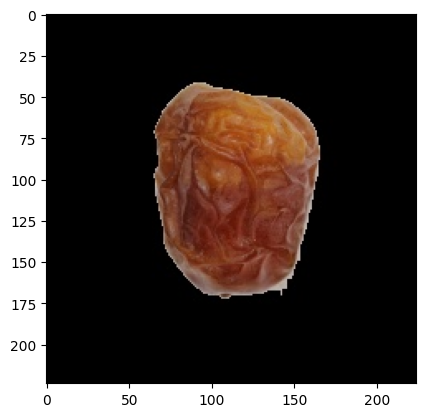

Dimensions of /kaggle/input/datafruit-after/datefruitAfter/data fruit/Rutab/Rutab Date (102).JPG: (224, 224, 3)


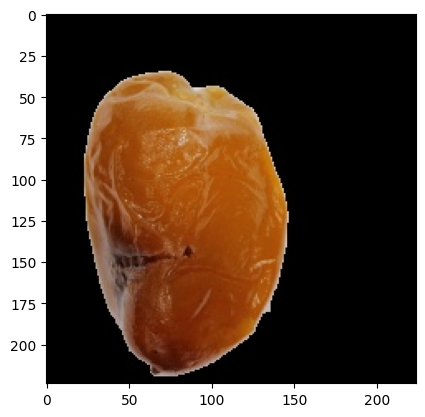

Dimensions of /kaggle/input/datafruit-after/datefruitAfter/data fruit/Sugaey/Sugaey Date (87).JPG: (224, 224, 3)


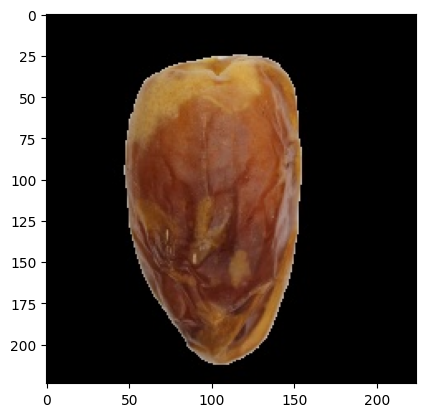

Dimensions of /kaggle/input/datafruit-after/datefruitAfter/data fruit/Medjool/Medjool Date (22).JPG: (224, 224, 3)


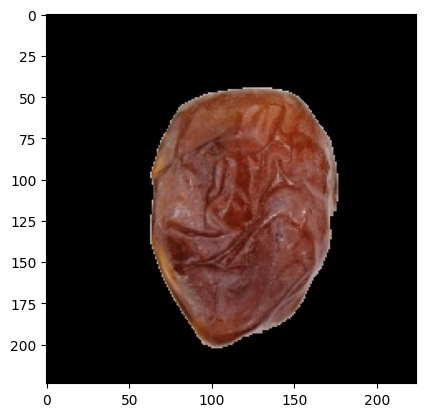

Dimensions of /kaggle/input/datafruit-after/datefruitAfter/data fruit/Nabtat Ali/Nabtat Ali Date (134).JPG: (224, 224, 3)


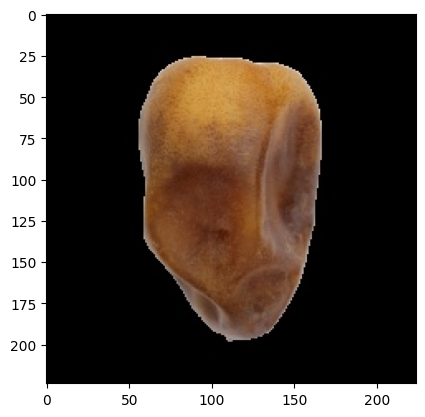

Dimensions of /kaggle/input/datafruit-after/datefruitAfter/data fruit/Sokari/Sokari Date (159).JPG: (224, 224, 3)


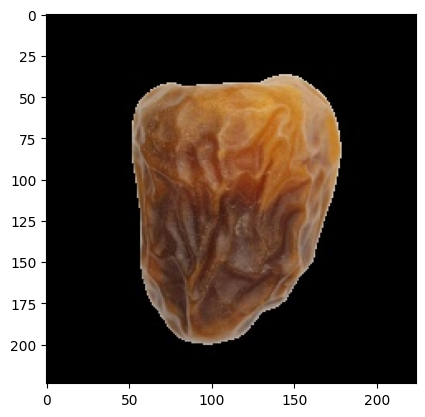

Dimensions of /kaggle/input/datafruit-after/datefruitAfter/data fruit/Shaishe/Shaishe Date (166).JPG: (224, 224, 3)


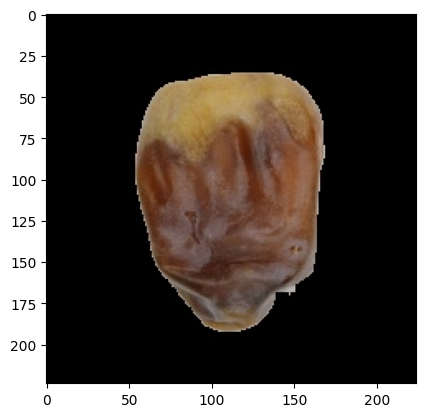

Dimensions of /kaggle/input/datafruit-after/datefruitAfter/data fruit/Meneifi/Meneifi Date (29).JPG: (224, 224, 3)


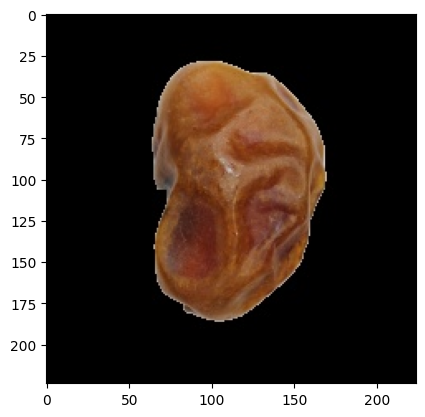

In [9]:
import cv2
import matplotlib.pyplot as plt
import os

def show_single_image_in_each_directory(folders):
    for i in folders:
        images = list(i.glob("*.*"))  
        if images:  # Check if there are any images
            image_path = str(images[0])  # Convert the Path object to string for cv2.imread
            img = cv2.imread(image_path)
            print(f"Dimensions of {image_path}: {img.shape}")

            # Convert BGR image to RGB for displaying
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            # Display the image
            plt.imshow(img_rgb)
            plt.show()
        else:
            print(f"No images found in {i}")


show_single_image_in_each_directory(folders)

In [10]:
import os
import shutil
from sklearn.model_selection import train_test_split
from tqdm import tqdm

def safe_copy(src_file, dest_file):
    """Copies a file to a new location, ensuring directories exist."""
    os.makedirs(os.path.dirname(dest_file), exist_ok=True)
    shutil.copy(src_file, dest_file)

def stratify_copy(source_dir, train_dir, val_dir, test_size=0.15, random_state=10):
    """Copies files for stratified train-test split without moving them."""
    classes = os.listdir(source_dir)
    for cls in classes:
        cls_dir = os.path.join(source_dir, cls)
        cls_files = [os.path.join(cls_dir, file) for file in os.listdir(cls_dir)]
        train_files, val_files = train_test_split(cls_files, test_size=test_size, random_state=random_state, stratify=[cls]*len(cls_files))

        # Copy files with progress bar
        for file in tqdm(train_files, desc=f"Copying {cls} - Train"):
            safe_copy(file, os.path.join(train_dir, cls, os.path.basename(file)))
        for file in tqdm(val_files, desc=f"Copying {cls} - Validation"):
            safe_copy(file, os.path.join(val_dir, cls, os.path.basename(file)))

def print_class_distribution(directory):
    """Prints the number of files in each class directory."""
    classes = os.listdir(directory)
    for cls in classes:
        cls_dir = os.path.join(directory, cls)
        count = len(os.listdir(cls_dir))
        print(f"{cls}: {count} images")

def check_distribution_thresholds(total_images, train_count, val_count, train_thresh=0.80, val_thresh=0.15):
    """Check if the class distribution in the train and validation sets meets the threshold requirements."""
    train_expected = total_images * train_thresh
    val_expected = total_images * val_thresh
    train_check = train_count >= train_expected
    val_check = val_count >= val_expected
    if not train_check or not val_check:
        print(f"Threshold not met for training: {train_check} (Expected at least {train_expected}, got {train_count}), "
              f"validation: {val_check} (Expected at least {val_expected}, got {val_count})")
    return train_check and val_check

source = '/kaggle/input/datafruit-after/datefruitAfter/data fruit'
train_dir = '/kaggle/output/train'  
val_dir = '/kaggle/output/val'  

# Perform the stratified copy
stratify_copy(source, train_dir, val_dir)

# Print the distribution of classes in training and validation directories
print("Training set distribution:")
print_class_distribution(train_dir)
print("Validation set distribution:")
print_class_distribution(val_dir)


total_images = {
    "Galaxy": 190, "Rutab": 146, "Sugaey": 168, "Medjool": 135,
    "Nabtat Ali": 177, "Sokari": 264, "Shaishe": 171, "Meneifi": 232
}
training_counts = {
    "Galaxy": 188, "Rutab": 145, "Sugaey": 167, "Medjool": 134,
    "Nabtat Ali": 175, "Sokari": 262, "Shaishe": 170, "Meneifi": 227
}
validation_counts = {
    "Galaxy": 56, "Rutab": 43, "Sugaey": 51, "Medjool": 41,
    "Nabtat Ali": 52, "Sokari": 78, "Shaishe": 51, "Meneifi": 65
}

for cls, total in total_images.items():
    train_count = training_counts[cls]
    val_count = validation_counts[cls]
    is_ok = check_distribution_thresholds(total, train_count, val_count)
    print(f"{cls} class balance is OK: {is_ok}")


Copying Meneifi - Validation: 100%|██████████| 35/35 [00:00<00:00, 346.09it/s]

Training set distribution:
Nabtat Ali: 150 images
Galaxy: 161 images
Sugaey: 142 images
Meneifi: 197 images
Sokari: 224 images
Rutab: 124 images
Medjool: 114 images
Shaishe: 145 images
Validation set distribution:
Nabtat Ali: 27 images
Galaxy: 29 images
Sugaey: 26 images
Meneifi: 35 images
Sokari: 40 images
Rutab: 22 images
Medjool: 21 images
Shaishe: 26 images
Galaxy class balance is OK: True
Rutab class balance is OK: True
Sugaey class balance is OK: True
Medjool class balance is OK: True
Nabtat Ali class balance is OK: True
Sokari class balance is OK: True
Shaishe class balance is OK: True
Meneifi class balance is OK: True


In [11]:



train_datagen = ImageDataGenerator(rescale=1./255)

validation_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators
train_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    directory=val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)






Found 1257 images belonging to 8 classes.
Found 226 images belonging to 8 classes.


In [12]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

def load_image_pil(image_path, target_size=(224, 224)):
    """Load and preprocess an image using PIL."""
    with Image.open(image_path) as img:
        img = img.convert('RGB')
        img = img.resize(target_size)
        img_array = np.array(img) / 255.0
    return img_array

def show_one_batch(data_generator):
    for _ in range(5):  # Display images from 5 batches
        images, labels = next(data_generator)
        
        for i in range(min(10, len(images))):  # Display only the first 10 images of each batch
            img = images[i]
            pil_img = Image.fromarray((img * 255).astype(np.uint8))
            plt.figure(figsize=(10, 5))
            plt.imshow(pil_img)
            title = np.argmax(labels[i]) if labels.ndim == 2 else labels[i]
            plt.title(f'Label: {title}')
            plt.axis('off')
            plt.show()

In [13]:
import os

def print_class_distribution(directory):
    """Prints the number of files in each class directory."""
    classes = os.listdir(directory)
    for cls in classes:
        cls_dir = os.path.join(directory, cls)
        count = len(os.listdir(cls_dir))
        print(f"{cls}: {count} images")

# Print the distribution of classes in training and validation directories
print("Training set distribution:")
print_class_distribution(train_dir)

print("Validation set distribution:")
print_class_distribution(val_dir)


Training set distribution:
Nabtat Ali: 150 images
Galaxy: 161 images
Sugaey: 142 images
Meneifi: 197 images
Sokari: 224 images
Rutab: 124 images
Medjool: 114 images
Shaishe: 145 images
Validation set distribution:
Nabtat Ali: 27 images
Galaxy: 29 images
Sugaey: 26 images
Meneifi: 35 images
Sokari: 40 images
Rutab: 22 images
Medjool: 21 images
Shaishe: 26 images


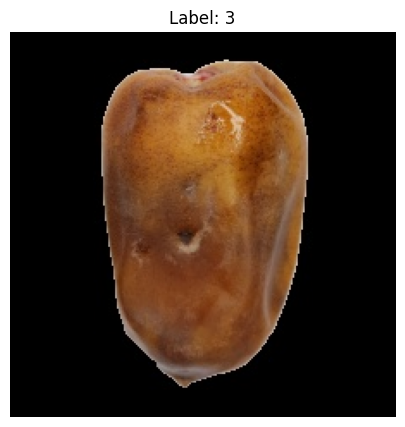

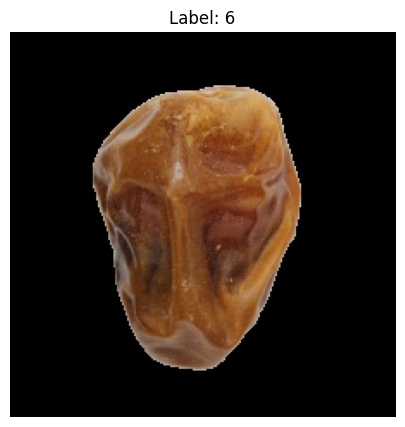

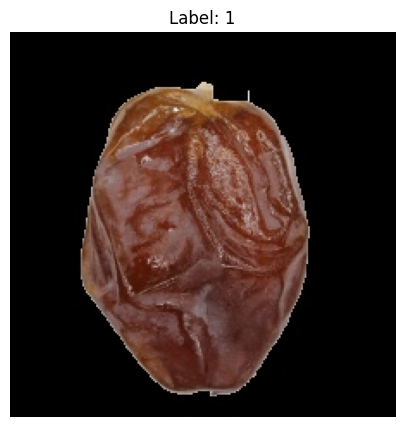

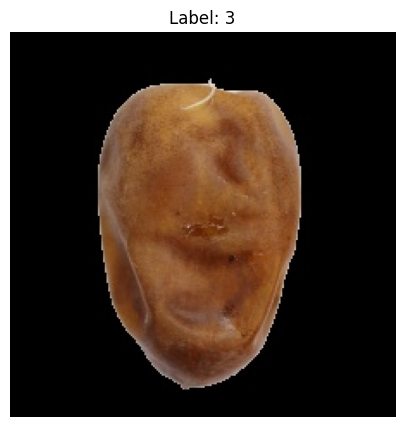

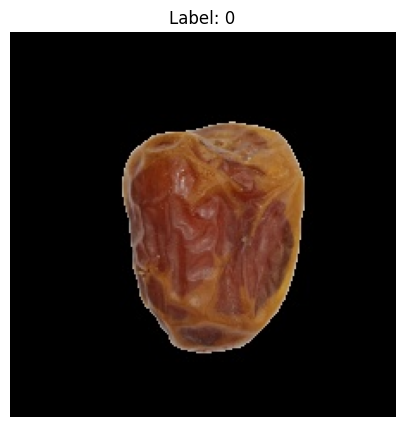

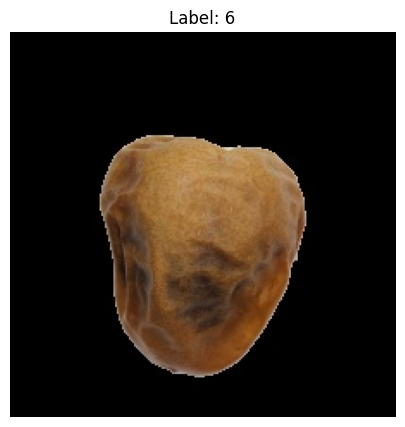

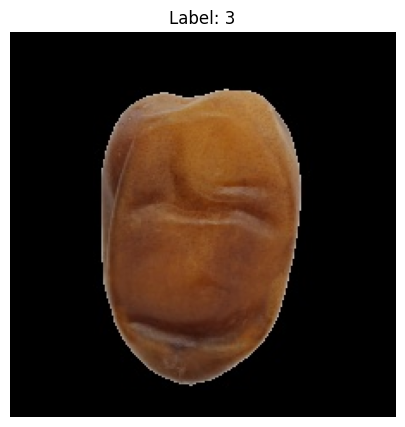

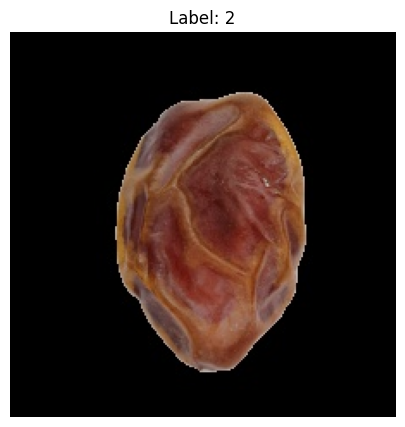

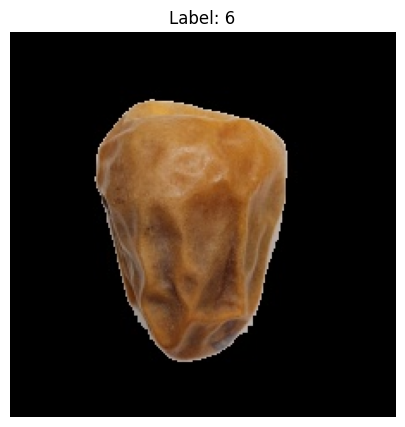

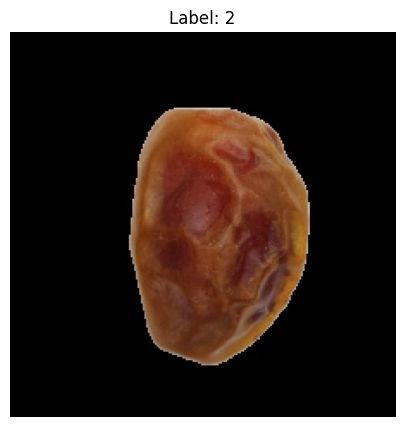

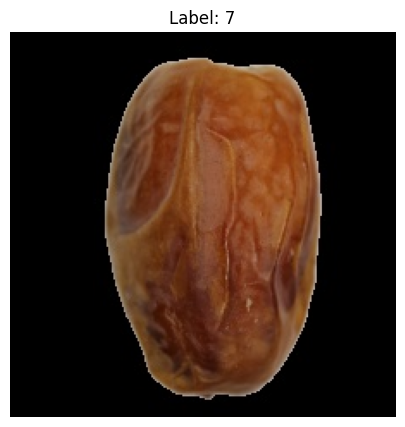

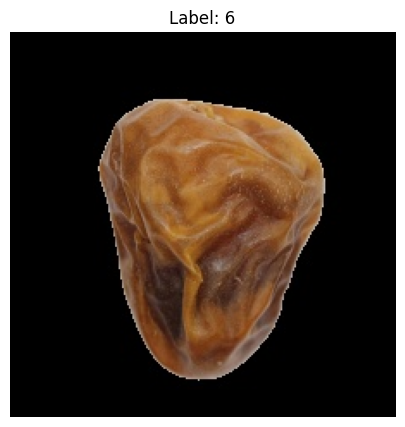

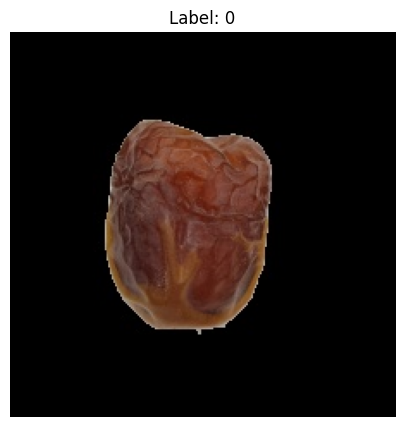

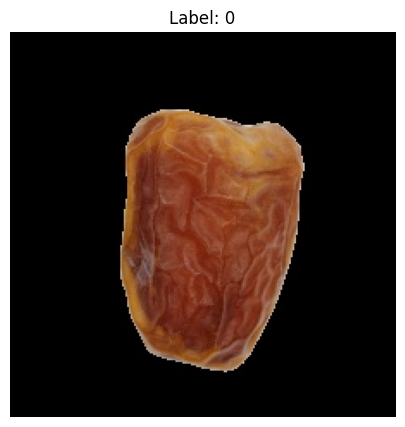

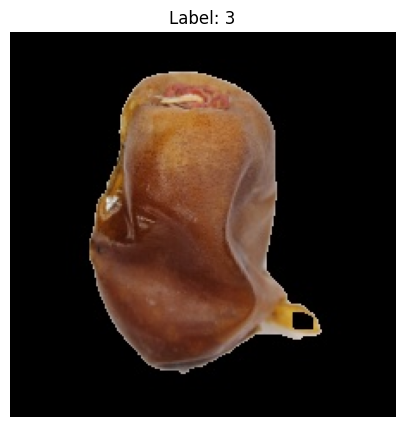

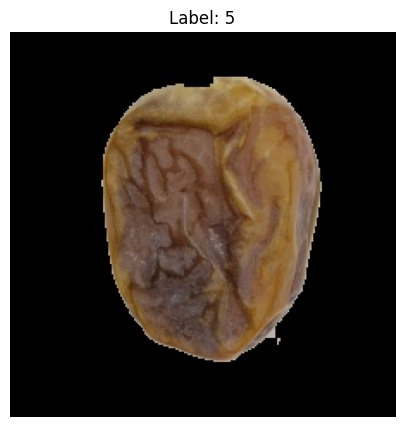

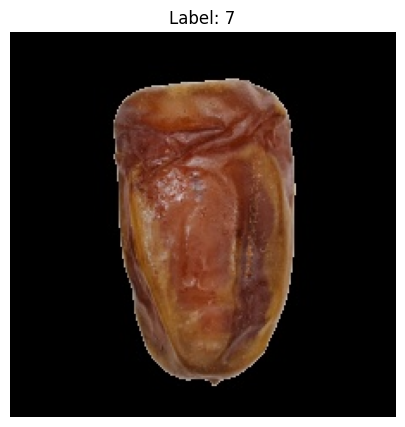

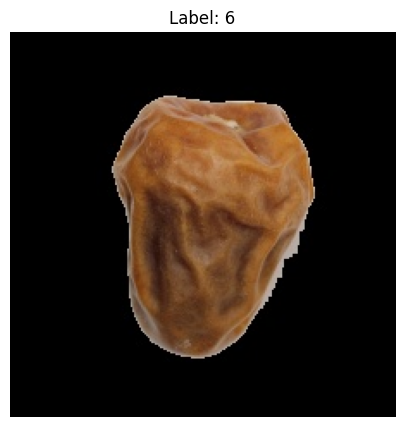

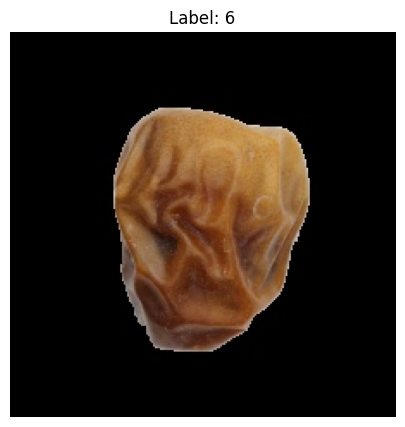

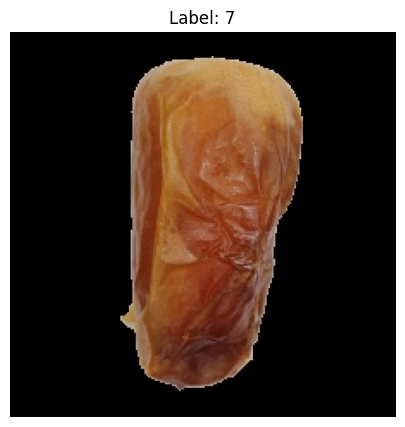

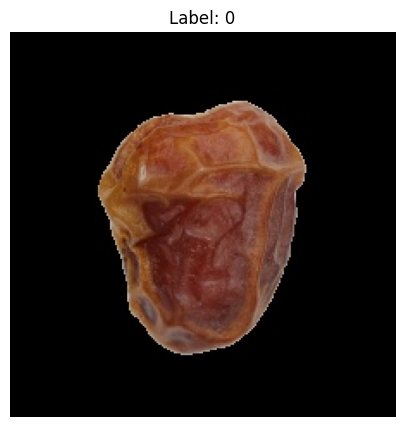

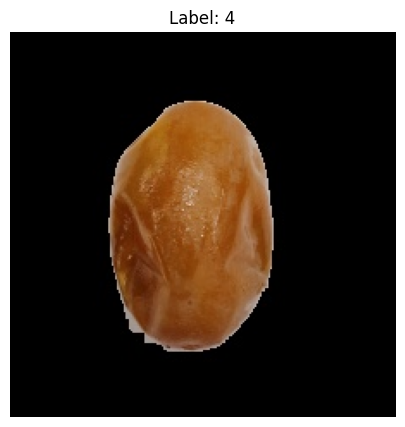

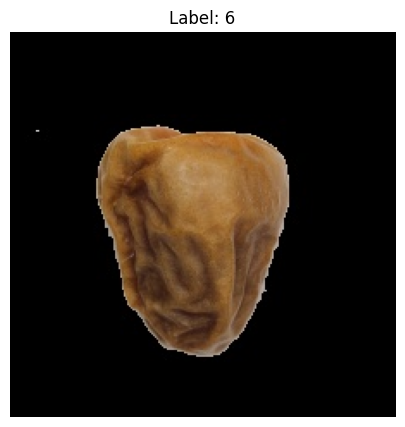

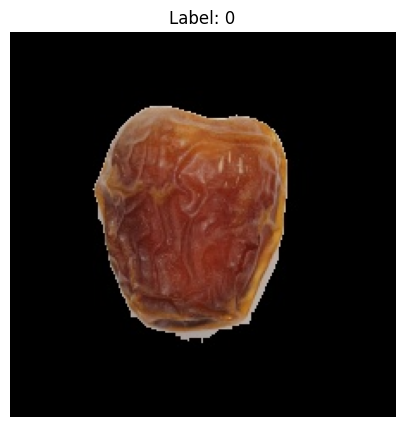

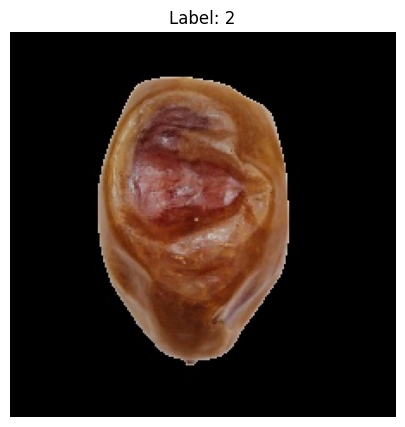

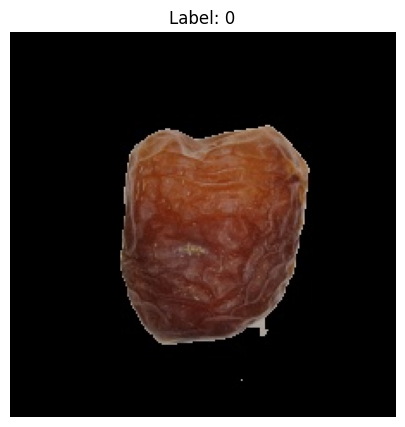

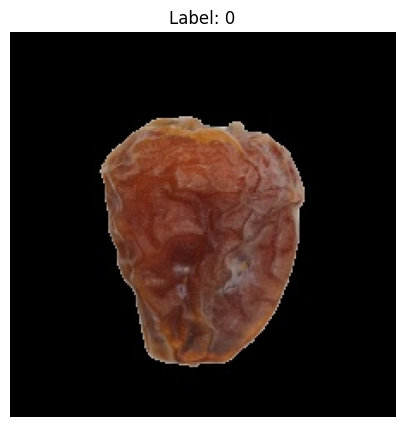

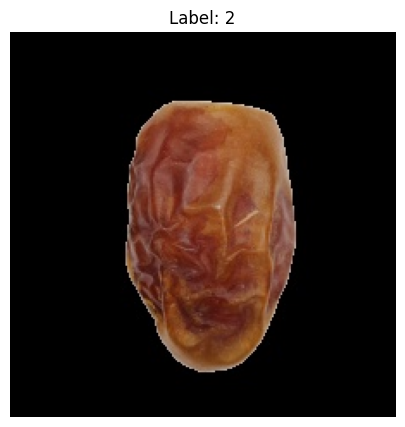

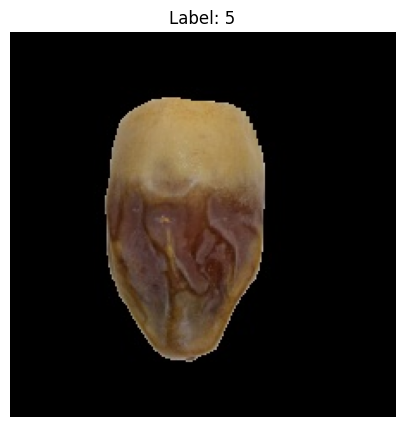

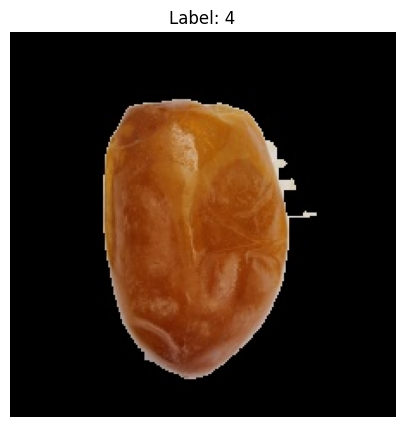

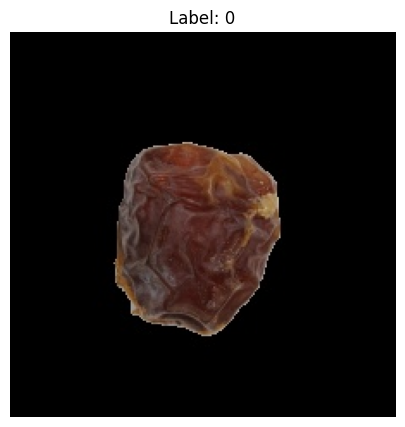

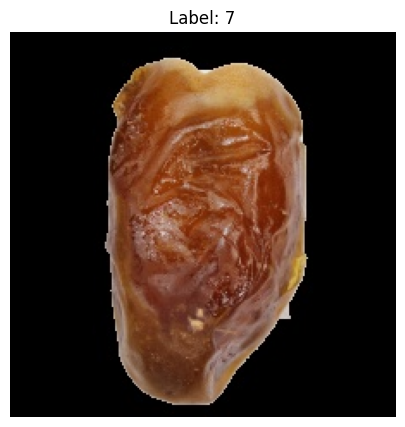

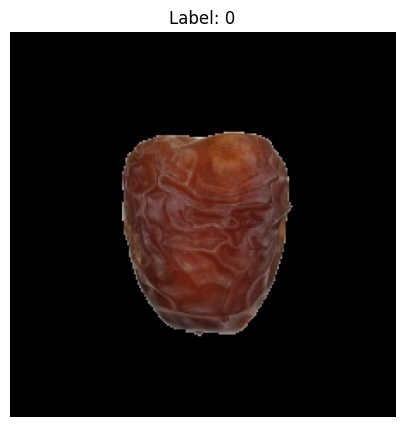

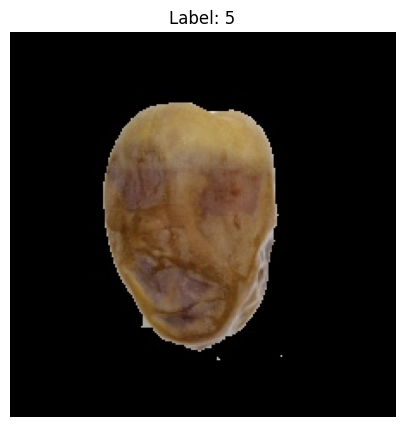

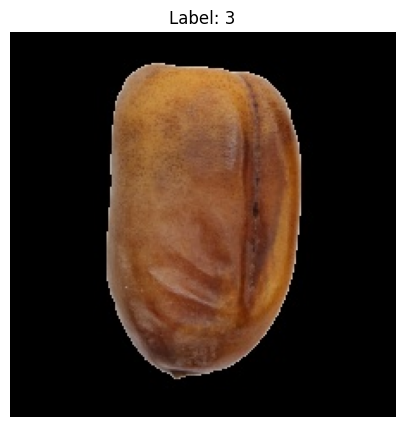

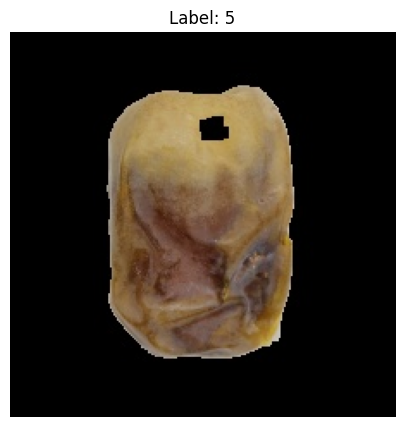

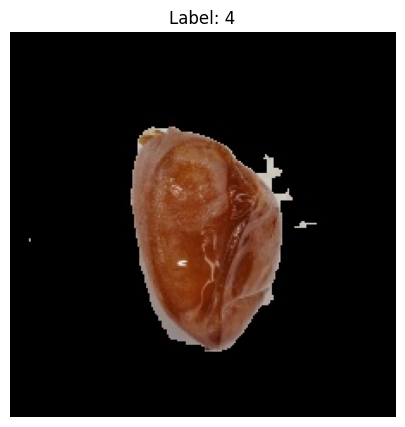

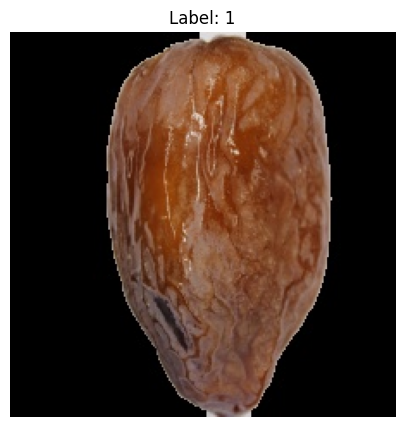

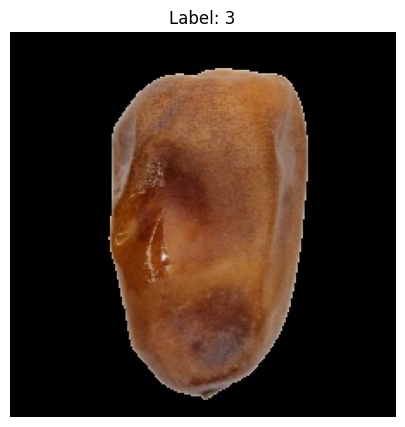

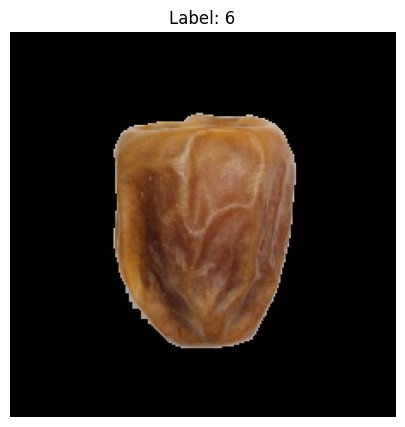

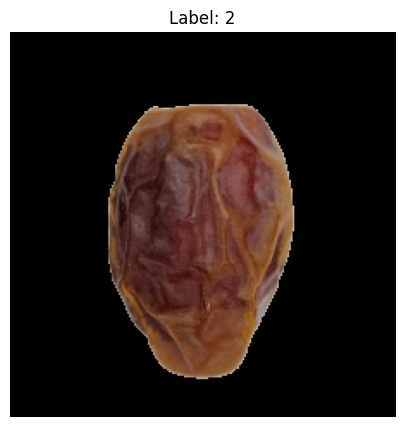

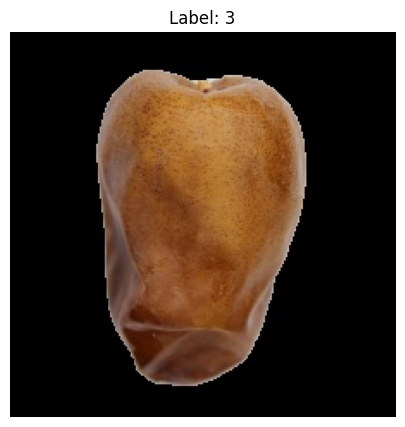

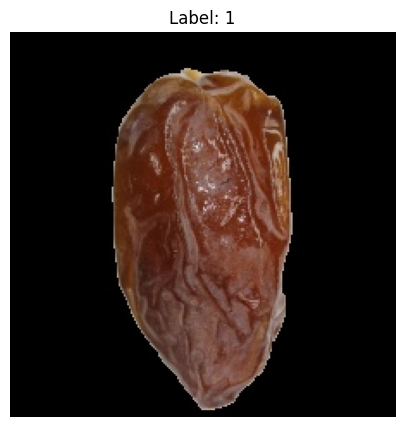

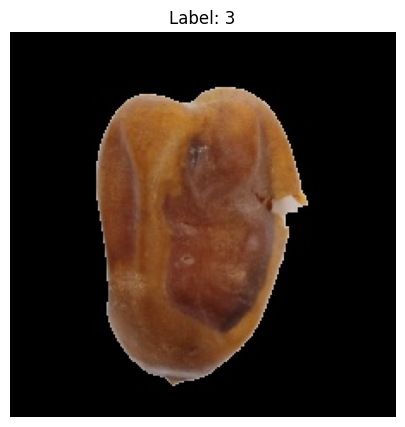

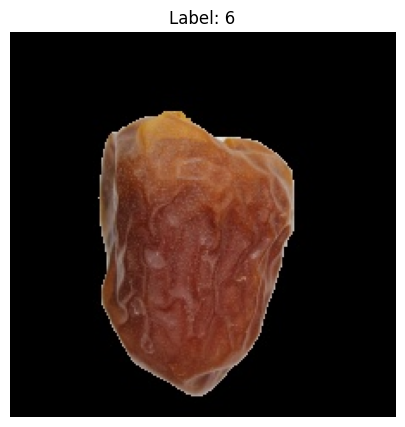

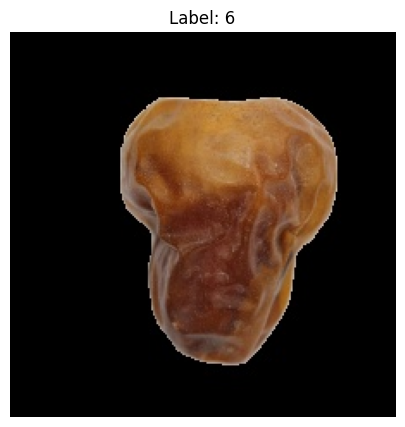

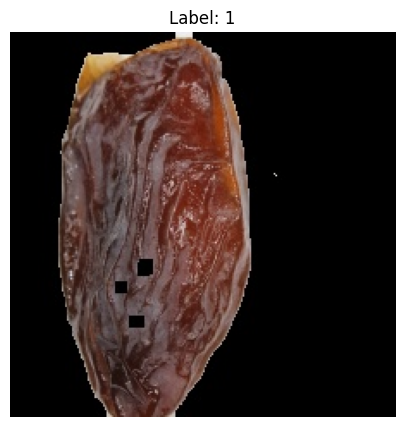

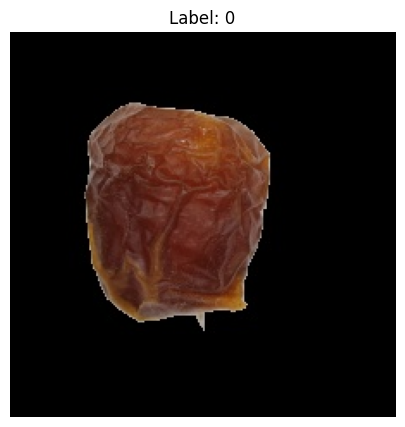

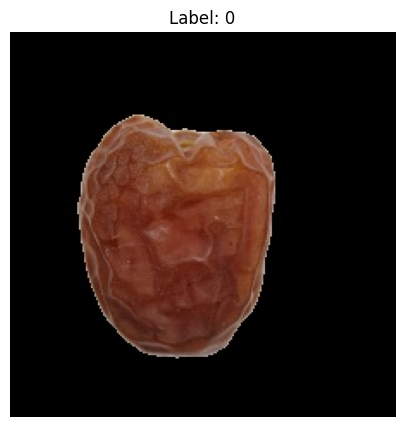

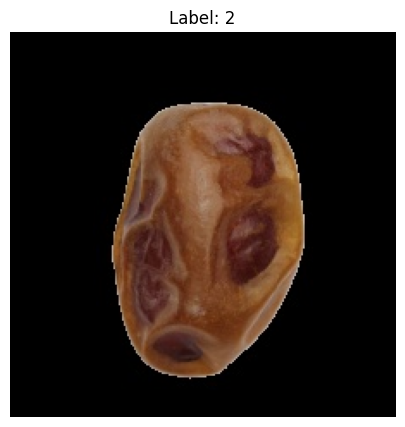

In [14]:
# Show one batch
show_one_batch(train_generator)


# Transfer Learning using mobilenet_v2
# 

In [15]:

mo = keras.applications.MobileNetV2(
    weights='imagenet', 
    include_top=False, 
    input_shape=(224, 224, 3)  
)

the_model = keras.layers.GlobalAveragePooling2D()(mo.output)
the_model = keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.04))(the_model)
the_model = keras.layers.Dropout(0.7)(the_model)  
predictions = keras.layers.Dense(8, activation='softmax')(the_model)  

# Create the final model
model = keras.models.Model(inputs=mo.input, outputs=predictions)

# Set the trainability of the base model layers
for layer in mo.layers[:100]:  
    layer.trainable = False
for layer in mo.layers[100:]:  
    layer.trainable = True
model.summary()   

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,984 (9.24 MB)

 Trainable params: 2,026,440 (7.73 MB)

 Non-trainable params: 396,544 (1.51 MB)

In [16]:
len(model.layers)

158

In [17]:
model.layers[100:]

[<ReLU name=block_11_expand_relu, built=True>,
 <DepthwiseConv2D name=block_11_depthwise, built=True>,
 <BatchNormalization name=block_11_depthwise_BN, built=True>,
 <ReLU name=block_11_depthwise_relu, built=True>,
 <Conv2D name=block_11_project, built=True>,
 <BatchNormalization name=block_11_project_BN, built=True>,
 <Add name=block_11_add, built=True>,
 <Conv2D name=block_12_expand, built=True>,
 <BatchNormalization name=block_12_expand_BN, built=True>,
 <ReLU name=block_12_expand_relu, built=True>,
 <DepthwiseConv2D name=block_12_depthwise, built=True>,
 <BatchNormalization name=block_12_depthwise_BN, built=True>,
 <ReLU name=block_12_depthwise_relu, built=True>,
 <Conv2D name=block_12_project, built=True>,
 <BatchNormalization name=block_12_project_BN, built=True>,
 <Add name=block_12_add, built=True>,
 <Conv2D name=block_13_expand, built=True>,
 <BatchNormalization name=block_13_expand_BN, built=True>,
 <ReLU name=block_13_expand_relu, built=True>,
 <ZeroPadding2D name=block_13_p

In [18]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adamax(learning_rate=base_learning_rate),
              loss="categorical_crossentropy",
              metrics=['accuracy', 'precision', 'recall', 'auc'])

In [19]:
call_1 = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
callbacks = [call_1]


# Training 

In [20]:
epochs=50
history = model.fit(
  train_generator,
  epochs=epochs,
  validation_data=validation_generator,
  callbacks = callbacks,
)

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 2/40 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.0938 - auc: 0.5375 - loss: 11.9375 - precision: 0.0952 - recall: 0.0312          

I0000 00:00:1716476142.990821      87 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


40/40 ━━━━━━━━━━━━━━━━━━━━ 48s 533ms/step - accuracy: 0.2118 - auc: 0.6062 - loss: 11.5660 - precision: 0.3004 - recall: 0.0836 - val_accuracy: 0.3584 - val_auc: 0.7055 - val_loss: 10.9338 - val_precision: 1.0000 - val_recall: 0.0088
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.4920 - auc: 0.8530 - loss: 10.4402 - precision: 0.6954 - recall: 0.2277 - val_accuracy: 0.4602 - val_auc: 0.7796 - val_loss: 10.5756 - val_precision: 0.6552 - val_recall: 0.0841
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.6875 - auc: 0.9389 - loss: 9.8676 - precision: 0.8810 - recall: 0.4300 - val_accuracy: 0.4867 - val_auc: 0.8179 - val_loss: 10.2996 - val_precision: 0.6719 - val_recall: 0.1903
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.7625 - auc: 0.9601 - loss: 9.5475 - precision: 0.8971 - recall: 0.5599 - val_accuracy: 0.4912 - val_auc: 0.8445 - val_loss: 10.0763 - val_precision: 0.6486 - val_recall: 0.3186
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 2

In [21]:
def drawing(p1, p2, p3, p4):
  a = p1[0]
  b = p2[0]
  c = p3[0]
  d = p4[0]
  plt.rcParams["figure.figsize"] = (20,4)
  mpl.style.use('seaborn')
  plt.plot(a,'blue', label=p1[1])
  plt.plot(b,'orange', label=p2[1])
  plt.plot(c,'red', label=p3[1])
  plt.plot(d,'green', label=p4[1])
  plt.legend()

/tmp/ipykernel_24/354503818.py:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  mpl.style.use('seaborn')


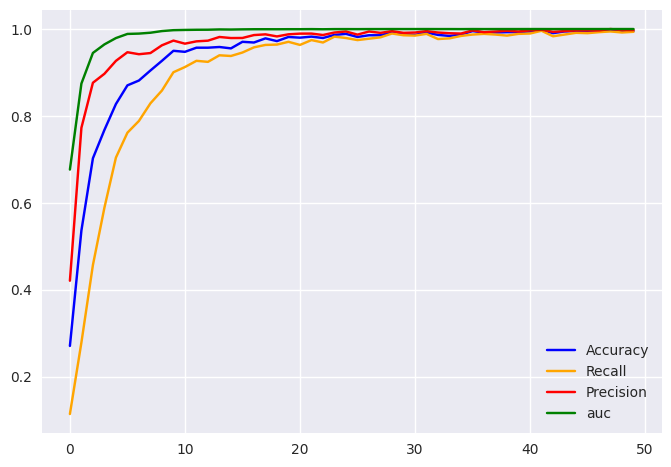

In [22]:
drawing(
    [history.history['accuracy'], 'Accuracy'],
    [history.history['recall'], 'Recall'],
    [history.history['precision'], 'Precision'],
    [history.history['auc'], 'auc']
)

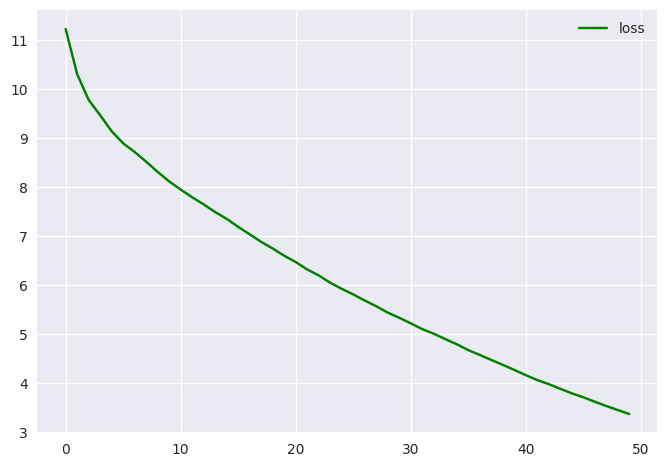

In [23]:
plt.plot(history.history['loss'],'green', label="loss")
plt.legend()

In [24]:
results = model.evaluate(
    validation_generator,
    batch_size=validation_generator.batch_size,
    steps=validation_generator.n // validation_generator.batch_size
)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9548 - auc: 0.9919 - loss: 3.5185 - precision: 0.9558 - recall: 0.9513


In [25]:
model.metrics_names

['loss', 'compile_metrics']

In [26]:
print (validation_generator.n // validation_generator.batch_size)

7


In [27]:
# Simplified test
results = model.evaluate(validation_generator, steps=1)  # Evaluate on just one step
for metric, value in zip(model.metrics_names, results):
    print(f"{metric}: {value}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.9688 - auc: 0.9997 - loss: 3.3551 - precision: 1.0000 - recall: 0.9688
loss: 3.355091094970703
compile_metrics: 0.96875


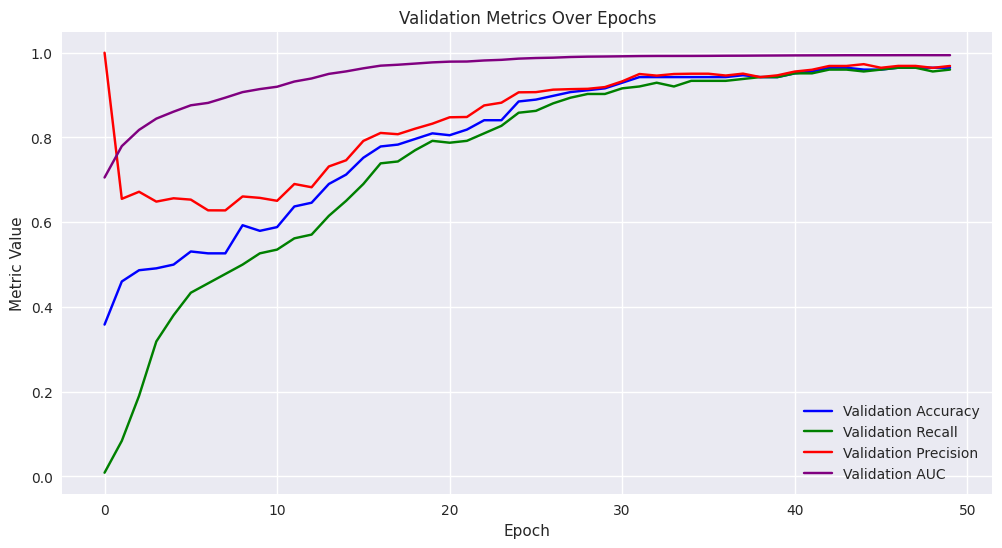

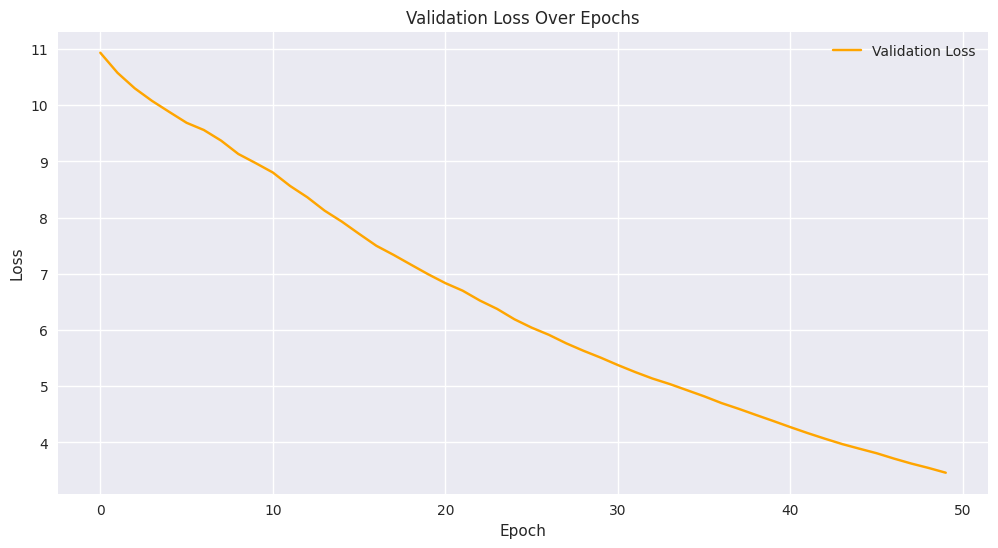

In [28]:
import matplotlib.pyplot as plt

# Plot for validation metrics: accuracy, recall, precision, and AUC
plt.figure(figsize=(12, 6))
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='blue')
plt.plot(history.history['val_recall'], label='Validation Recall', color='green')
plt.plot(history.history['val_precision'], label='Validation Precision', color='red')
plt.plot(history.history['val_auc'], label='Validation AUC', color='purple')
plt.title('Validation Metrics Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.legend()
plt.show()

# Plot for validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [29]:
validation_generator.reset()

In [30]:
Y_pred = model.predict(validation_generator)


8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 446ms/step


In [31]:
y_pred = np.argmax(Y_pred ,  axis = 1)

In [32]:
y_pred

array([6, 6, 1, 7, 4, 6, 6, 5, 4, 3, 7, 2, 7, 5, 7, 4, 2, 5, 0, 2, 5, 4,
       7, 7, 1, 1, 1, 0, 5, 6, 7, 6, 1, 2, 6, 4, 3, 3, 7, 0, 5, 0, 2, 7,
       0, 6, 6, 3, 2, 0, 7, 5, 2, 1, 6, 0, 0, 7, 6, 7, 1, 4, 5, 6, 1, 6,
       2, 3, 6, 5, 0, 1, 2, 7, 4, 0, 2, 6, 3, 7, 3, 6, 2, 2, 1, 0, 6, 3,
       3, 6, 2, 4, 2, 6, 7, 6, 6, 6, 1, 6, 7, 6, 2, 6, 0, 0, 1, 2, 4, 6,
       3, 4, 0, 3, 3, 0, 6, 4, 7, 2, 3, 0, 6, 5, 6, 0, 0, 1, 1, 3, 2, 1,
       2, 4, 6, 7, 4, 6, 2, 3, 6, 1, 3, 2, 7, 0, 4, 5, 7, 7, 5, 5, 4, 6,
       2, 1, 2, 4, 4, 0, 2, 6, 5, 7, 0, 2, 0, 4, 6, 6, 3, 1, 6, 2, 5, 3,
       4, 5, 3, 6, 6, 4, 2, 6, 5, 5, 0, 3, 5, 5, 3, 0, 3, 6, 3, 7, 1, 6,
       0, 0, 7, 6, 5, 7, 2, 2, 5, 2, 2, 4, 4, 6, 3, 5, 7, 5, 0, 3, 5, 2,
       2, 2, 7, 4, 3, 1])

In [33]:
validation_generator.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7], dtype=int32)

In [34]:
len(y_pred)

226

In [35]:
len(validation_generator.classes)

226

In [36]:
res = tf.math.confusion_matrix(y_pred,validation_generator.classes).numpy()

In [37]:
confusion_matrix = pd.DataFrame(res,
                     index = classes_name,
                     columns = classes_name)

In [38]:
confusion_matrix

Galaxy  Medjool  Meneifi  Nabtat Ali  Rutab  Shaishe  Sokari  \
Galaxy           2        4        4           3      5        2       6   
Medjool          4        1        5           2      3        2       2   
Meneifi          3        3        6           4      3        4       4   
Nabtat Ali       1        3        3           3      4        2       7   
Rutab            4        1        2           3      2        5       3   
Shaishe          5        1        3           0      1        3       7   
Sokari           4        5        7          10      3        4       9   
Sugaey           6        3        5           2      1        4       2   

            Sugaey  
Galaxy           1  
Medjool          1  
Meneifi          7  
Nabtat Ali       3  
Rutab            3  
Shaishe          5  
Sokari           2  
Sugaey           4

/tmp/ipykernel_24/1993059714.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  mpl.style.use('seaborn')


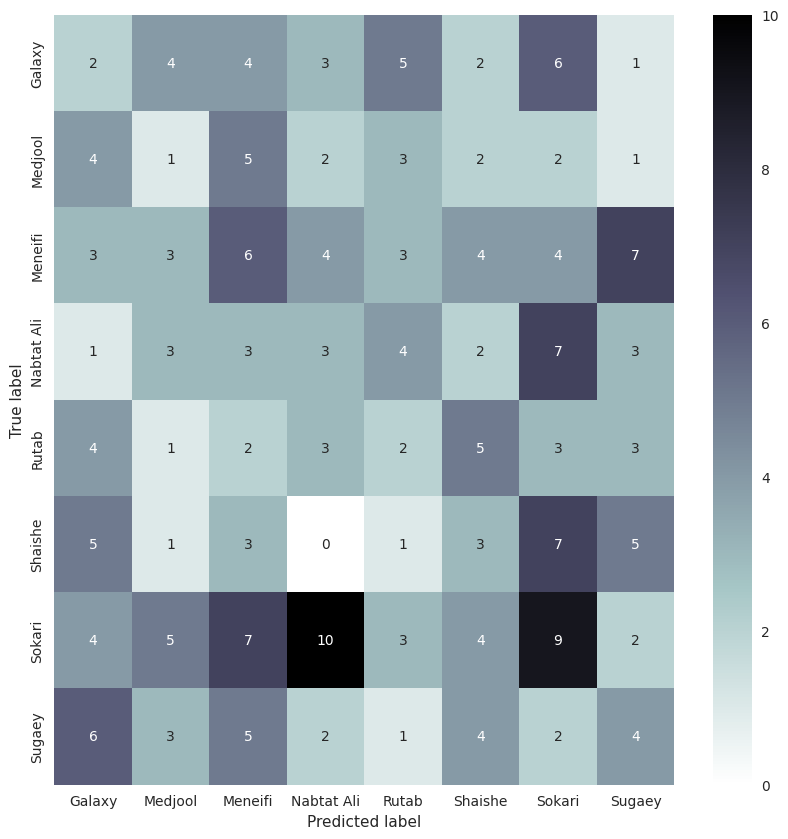

In [39]:
import seaborn as sns
mpl.style.use('seaborn')
figure = plt.figure(figsize=(10, 10))
sns.heatmap(confusion_matrix, annot=True, cmap=plt.cm.bone_r)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [40]:
classifi_report = classification_report(validation_generator.classes, y_pred,target_names = classes_name)
print(classifi_report)

              precision    recall  f1-score   support

      Galaxy       0.07      0.07      0.07        29
     Medjool       0.05      0.05      0.05        21
     Meneifi       0.18      0.17      0.17        35
  Nabtat Ali       0.12      0.11      0.11        27
       Rutab       0.09      0.09      0.09        22
     Shaishe       0.12      0.12      0.12        26
      Sokari       0.20      0.23      0.21        40
      Sugaey       0.15      0.15      0.15        26

    accuracy                           0.13       226
   macro avg       0.12      0.12      0.12       226
weighted avg       0.13      0.13      0.13       226



# ResNet model 

In [41]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import classification_report
# Metrics and Callbacks
metrics = [
    tf.keras.metrics.TruePositives(name='tp'),
    tf.keras.metrics.FalsePositives(name='fp'),
    tf.keras.metrics.TrueNegatives(name='tn'),
    tf.keras.metrics.FalseNegatives(name='fn'),
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.AUC(name='auc')
]

In [42]:
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='loss', patience=30, restore_best_weights=True)]


In [43]:
def create_resnet_model():
    base_model = keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    
    # Add a new top to the model
    x = base_model.output
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dense(256, activation='relu')(x)  
    x = keras.layers.BatchNormalization()(x)  
    x = keras.layers.Dropout(0.5)(x)  
    x = keras.layers.Dense(128, activation='relu')(x)
    x = keras.layers.BatchNormalization()(x)  
    predictions = keras.layers.Dense(8, activation='softmax')(x)

    model = keras.models.Model(inputs=base_model.input, outputs=predictions)

    # Fine-tuning more layers
    for layer in base_model.layers[:100]:  # Unfreeze earlier layers
        layer.trainable = False
    for layer in base_model.layers[100:]:
        layer.trainable = True

    # Use Adam optimizer with a lower learning rate
    model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss="categorical_crossentropy",
    metrics=[
        'accuracy',
        Precision(name='precision'),
        Recall(name='recall'),
        AUC(name='auc'),
        TruePositives(name='tp'),
        FalsePositives(name='fp'),
        TrueNegatives(name='tn'),
        FalseNegatives(name='fn')
    ]
)

    return model


In [44]:
res_net_model = create_resnet_model()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [45]:
history_res_net = res_net_model.fit(train_generator, epochs=50, validation_data=validation_generator, callbacks=callbacks)


Epoch 1/50
 2/40 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - accuracy: 0.0938 - auc: 0.5248 - fn: 47.0000 - fp: 11.0000 - loss: 2.6689 - precision: 0.0667 - recall: 0.0156 - tn: 325.0000 - tp: 1.0000            

W0000 00:00:1716476339.646931      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step - accuracy: 0.3260 - auc: 0.7190 - fn: 490.6000 - fp: 126.9750 - loss: 1.9565 - precision: 0.4666 - recall: 0.1865 - tn: 4316.1001 - tp: 144.1250

W0000 00:00:1716476364.070825      84 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


40/40 ━━━━━━━━━━━━━━━━━━━━ 68s 727ms/step - accuracy: 0.3285 - auc: 0.7210 - fn: 500.5854 - fp: 130.0732 - loss: 1.9490 - precision: 0.4694 - recall: 0.1889 - tn: 4419.2441 - tp: 149.3171 - val_accuracy: 0.0973 - val_auc: 0.4895 - val_fn: 226.0000 - val_fp: 0.0000e+00 - val_loss: 2.2963 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_tn: 1582.0000 - val_tp: 0.0000e+00
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 104ms/step - accuracy: 0.5939 - auc: 0.9105 - fn: 328.4390 - fp: 118.3659 - loss: 1.1117 - precision: 0.7340 - recall: 0.4908 - tn: 4458.4390 - tp: 325.3903 - val_accuracy: 0.1195 - val_auc: 0.4935 - val_fn: 226.0000 - val_fp: 0.0000e+00 - val_loss: 2.1699 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_tn: 1582.0000 - val_tp: 0.0000e+00
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 105ms/step - accuracy: 0.7078 - auc: 0.9520 - fn: 253.2439 - fp: 119.2927 - loss: 0.8150 - precision: 0.7651 - recall: 0.6159 - tn: 4418.2441 - tp: 394.9756 - val_accuracy: 0.0929 - val

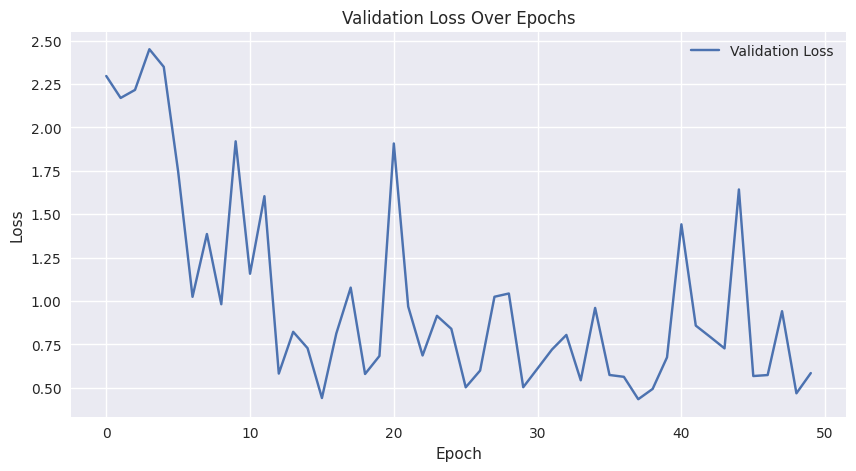

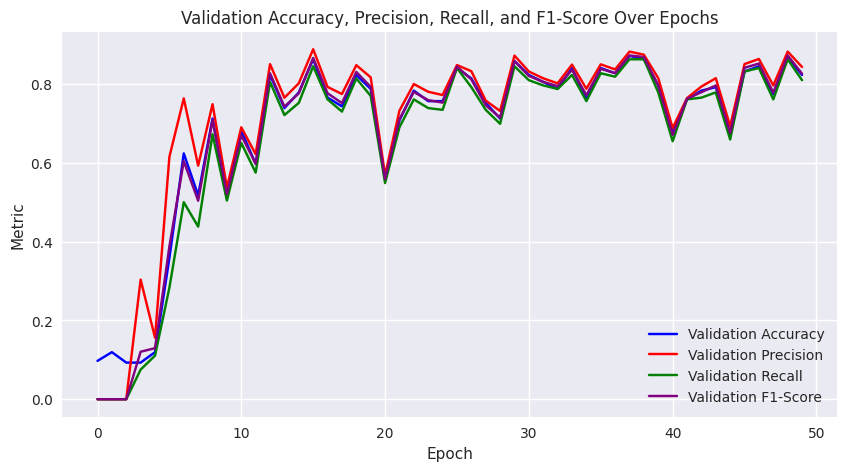

In [46]:
import matplotlib.pyplot as plt

def plot_validation_loss(history):
    # Plot validation loss
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Validation Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def plot_accuracy_precision_recall_f1(history):
    # Calculate F1-score from precision and recall for each epoch
    precision = history.history['val_precision']
    recall = history.history['val_recall']
    f1_score = [2 * (p * r) / (p + r) if (p + r) != 0 else 0 for p, r in zip(precision, recall)]

    # Plot accuracy, precision, recall, and F1-score
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='blue')
    plt.plot(history.history['val_precision'], label='Validation Precision', color='red')
    plt.plot(history.history['val_recall'], label='Validation Recall', color='green')
    plt.plot(f1_score, label='Validation F1-Score', color='purple')
    plt.title('Validation Accuracy, Precision, Recall, and F1-Score Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Metric')
    plt.legend()
    plt.show()

plot_validation_loss(history_res_net)
plot_accuracy_precision_recall_f1(history_res_net)


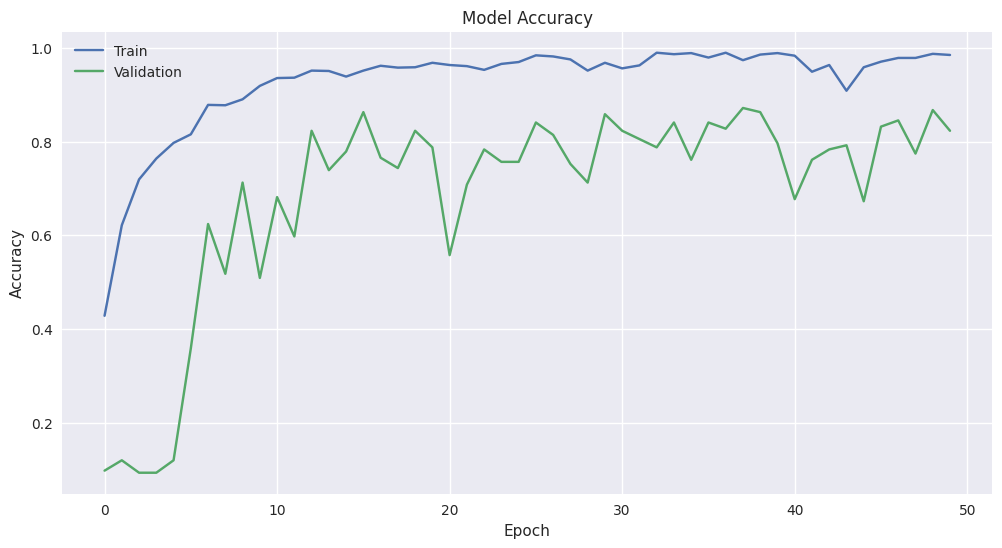

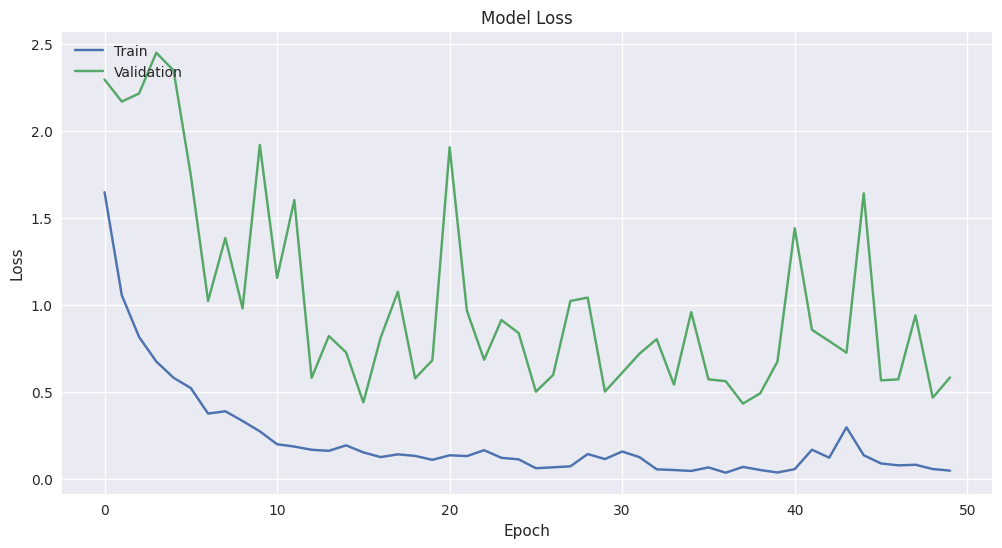

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.8304 - auc: 0.9743 - fn: 24.1250 - fp: 21.5000 - loss: 0.5664 - precision: 0.8376 - recall: 0.8245 - tn: 958.5000 - tp: 115.8750
loss: 0.5620
compile_metrics: 0.8304
5/8 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step

W0000 00:00:1716476591.225650      85 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 634ms/step


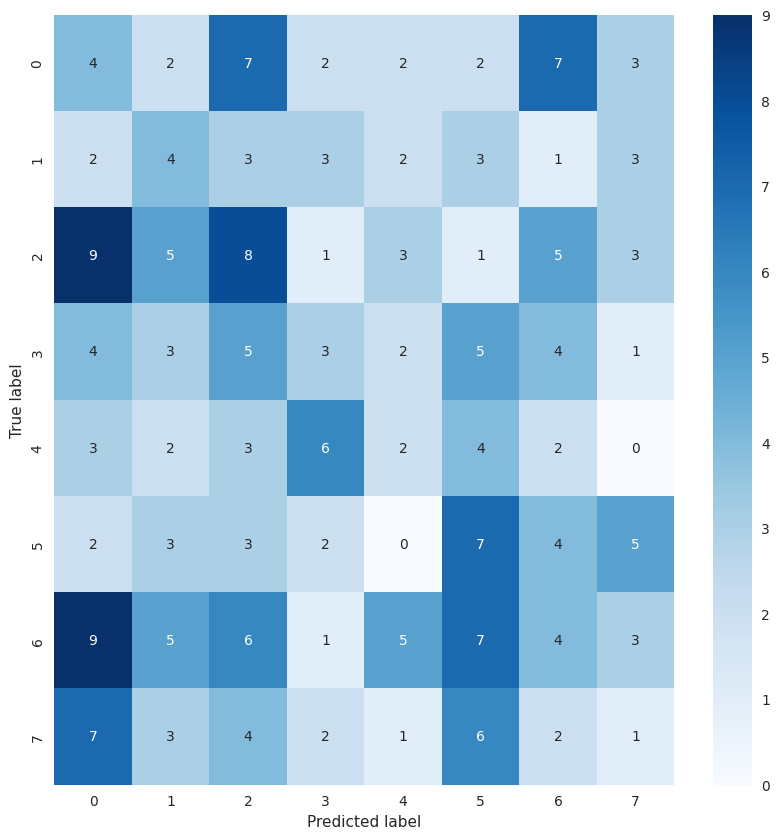

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
              precision    recall  f1-score   support

      Galaxy       0.20      0.28      0.23        29
     Medjool       0.11      0.14      0.12        21
     Meneifi       0.18      0.20      0.19        35
  Nabtat Ali       0.10      0.07      0.09        27
       Rutab       0.06      0.05      0.05        22
     Shaishe       0.14      0.19      0.16        26
      Sokari       0.17      0.12      0.14        40
      Sugaey       0.16      0.12      0.13        26

    accuracy                           0.15       226
   macro avg       0.14      0.15      0.14       226
weighted avg       0.15      0.15      0.15       226



In [47]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

def plot_training_history(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

def evaluate_model(model, validation_generator):
    # Calculate the number of steps (batches of samples) to evaluate the entire validation set
    steps = validation_generator.n // validation_generator.batch_size
    
    # Evaluate the model
    results = model.evaluate(validation_generator, steps=steps)
    
    # Get metric names directly from the model's compiled metrics
    metrics_names = [metric.name for metric in model.metrics]
    
    # Print each metric with its corresponding value
    for metric, value in zip(metrics_names, results):
        print(f"{metric}: {value:.4f}")


def plot_confusion_matrix(model, validation_generator):
    validation_generator.reset()
    Y_pred = model.predict(validation_generator)
    y_pred = np.argmax(Y_pred, axis=1)
    matrix = confusion_matrix(validation_generator.classes, y_pred)
    plt.figure(figsize=(10, 10))
    sns.heatmap(matrix, annot=True, cmap=plt.cm.Blues, fmt='g')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.show()

def display_classification_report(model, validation_generator):
    validation_generator.reset()
    Y_pred = model.predict(validation_generator)
    y_pred = np.argmax(Y_pred, axis=1)
    report = classification_report(validation_generator.classes, y_pred, target_names=validation_generator.class_indices.keys())
    print(report)

plot_training_history(history_res_net)
evaluate_model(res_net_model, validation_generator)
plot_confusion_matrix(res_net_model, validation_generator)
display_classification_report(res_net_model, validation_generator)